# Post-processing for fiber section responses

This example is adapted from:

[Reinforced Concrete Frame Pushover Analysis](https://openseespydoc.readthedocs.io/en/latest/src/RCFramePushOver.html)

In [1]:
import opstool as opst
import openseespy.opensees as ops
import matplotlib.pyplot as plt

## Model

In [2]:
ops.wipe()
ops.model("basic", "-ndm", 3, "-ndf", 6)
width = 360.0
height = 144.0
ops.node(1, 0.0, 0.0, 0.0)
ops.node(2, width, 0.0, 0.0)
ops.node(3, 0.0, 0.0, height)
ops.node(4, width, 0.0, height)
ops.fix(1, 1, 1, 1, 1, 1, 1)
ops.fix(2, 1, 1, 1, 1, 1, 1)

ops.uniaxialMaterial("Concrete01", 1, -6.0, -0.004, -5.0, -0.014)
ops.uniaxialMaterial("Concrete01", 2, -5.0, -0.002, 0.0, -0.006)

fy = 60.0
E = 30000.0
ops.uniaxialMaterial("Steel01", 3, fy, E, 0.01)

# Define cross-section for nonlinear columns
# ------------------------------------------
colWidth = 15
colDepth = 24
cover = 1.5
As = 0.60  # area of no. 7 bars
# some variables derived from the parameters
y1 = colDepth / 2.0
z1 = colWidth / 2.0

ops.section("Fiber", 1, "-GJ", 1000000)
ops.patch("rect", 1, 10, 10, cover - y1, cover - z1, y1 - cover, z1 - cover)
# Create the concrete cover fibers (top, bottom, left, right)
ops.patch("rect", 2, 11, 1, -y1, z1 - cover, y1, z1)
ops.patch("rect", 2, 11, 1, -y1, -z1, y1, cover - z1)
ops.patch("rect", 2, 1, 10, -y1, cover - z1, cover - y1, z1 - cover)
ops.patch("rect", 2, 1, 10, y1 - cover, cover - z1, y1, z1 - cover)
# Create the reinforcing fibers (left, middle, right)
ops.layer("straight", 3, 5, As, y1 - cover, z1 - cover, y1 - cover, cover - z1)
ops.layer("straight", 3, 2, As, 0.0, z1 - cover, 0.0, cover - z1)
ops.layer("straight", 3, 5, As, cover - y1, z1 - cover, cover - y1, cover - z1)

# Define column elements
# ----------------------
ops.geomTransf("PDelta", 1, -1, 0, 0)
# Number of integration points along length of element
np = 5
# Lobatto integratoin
ops.beamIntegration("Lobatto", 1, 1, np)
eleType = "forceBeamColumn"
ops.element(eleType, 1, 1, 3, 1, 1)
ops.element(eleType, 2, 2, 4, 1, 1)

# Define beam elment
# -----------------------------
ops.geomTransf("Linear", 2, 0.0, 0.0, 1.0)
ops.element("elasticBeamColumn", 3, 3, 4, 360.0, 4030.0, 2015.0, 10000, 8640.0, 8640.0, 2)

OPSTOOL ::  Model data has been saved to _OPSTOOL_ODB/ModelData-None.nc!

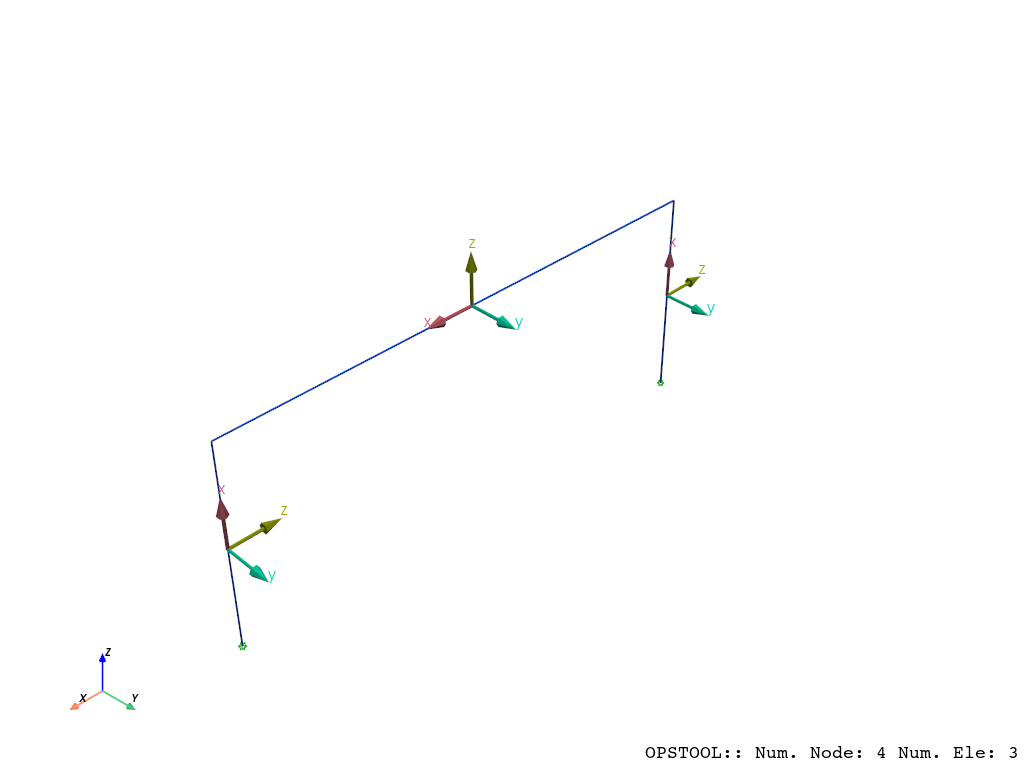

In [3]:
opst.vis.pyvista.set_plot_props(notebook=True)  # you should not use
fig = opst.vis.pyvista.plot_model(show_local_axes=True)
fig.show(jupyter_backend="jupyterlab")
# fig.show()

## Gravity analysis

In [4]:
# Define gravity loads
# --------------------

#  a parameter for the axial load
P = 180.0  # 10% of axial capacity of columns

# Create a Plain load pattern with a Linear TimeSeries
ops.timeSeries("Linear", 1)
ops.pattern("Plain", 1, 1)

# Create nodal loads at nodes 3 & 4
#    nd  FX,  FY, MZ
ops.load(3, 0.0, 0.0, -P, 0.0, 0.0, 0.0)
ops.load(4, 0.0, 0.0, -P, 0.0, 0.0, 0.0)

# Start of analysis generation
# ------------------------------
ops.system("BandGeneral")
ops.constraints("Transformation")
ops.numberer("RCM")
ops.test("NormDispIncr", 1.0e-12, 10, 3)
ops.algorithm("Newton")
ops.integrator("LoadControl", 0.1)
ops.analysis("Static")
ops.analyze(10)

0

## Pushover analysis

Define lateral loads

In [5]:
ops.loadConst("-time", 0.0)
# Define lateral loads
# --------------------
# Set some parameters
H = 10.0  # Reference lateral load
# Set lateral load pattern with a Linear TimeSeries
ops.pattern("Plain", 2, 1)
ops.load(3, H, 0.0, 0.0, 0.0, 0.0, 0.0)
ops.load(4, H, 0.0, 0.0, 0.0, 0.0, 0.0)


Start of modifications to analysis for push over

In [6]:
# Set some parameters
dU = 0.1  # Displacement increment
ops.integrator("DisplacementControl", 3, 1, dU)
# Set some parameters
maxU = 15.0  # Max displacement
currentDisp = 0.0
ok = 0

ops.test("NormDispIncr", 1.0e-6, 1000)
ops.algorithm("ModifiedNewton", "-initial")

Save the responses.
Args see [CreateODB](https://opstool.readthedocs.io/en/latest/src/api/_autosummary/opstool.post.CreateODB.html#opstool.post.CreateODB)

In [7]:
ODB = opst.post.CreateODB(odb_tag=1, fiber_ele_tags="ALL")
while ok == 0 and currentDisp < maxU:
    ok = ops.analyze(1)

    # if the analysis fails try initial tangent iteration
    if ok != 0:
        print("modified newton failed")
        break

    ODB.fetch_response_step()

    currentDisp = ops.nodeDisp(3, 1)

ODB.save_response()

OPSTOOL ::  All responses data with _odb_tag = 1 saved in _OPSTOOL_ODB/RespStepData-1.nc!

## Post-processing

### Fiber Section

Extracting fiber cross responses

In [8]:
sec_resp = opst.post.get_element_responses(odb_tag=1, ele_type="FiberSection")
print(sec_resp.data_vars)
print("-" * 100)
print(sec_resp.dims)
print("-" * 100)
print(sec_resp.coords)

OPSTOOL ::  Loading FiberSection response data from _OPSTOOL_ODB/RespStepData-1.nc ...

Data variables:
    Stresses  (time, eleTags, secPoints, fiberPoints) float64 2MB -0.3583 ......
    Strains   (time, eleTags, secPoints, fiberPoints) float64 2MB -0.0001213 ...
    secDefo   (time, eleTags, secPoints, DOFs) float64 49kB -0.0001213 ... 1....
    secForce  (time, eleTags, secPoints, DOFs) float64 49kB -180.0 ... 1.685e-15
    ys        (eleTags, secPoints, fiberPoints) float64 12kB -9.45 ... -10.5
    zs        (eleTags, secPoints, fiberPoints) float64 12kB -5.4 -5.4 ... -6.0
    areas     (eleTags, secPoints, fiberPoints) float64 12kB 2.52 2.52 ... 0.6
    matTags   (eleTags, secPoints, fiberPoints) float64 12kB 1.0 1.0 ... 3.0 3.0
----------------------------------------------------------------------------------------------------
FrozenMappingWarningOnValuesAccess({'time': 152, 'eleTags': 2, 'secPoints': 5, 'fiberPoints': 154, 'DOFs': 4})
----------------------------------------------------------------------------------------------------
Coordinates:
  * eleTags      

We can select the responses of element 1 and its first section.

In [9]:
stress = sec_resp["Stresses"].sel(eleTags=1, secPoints=1).isel(time=-1)
strain = sec_resp["Strains"].sel(eleTags=1, secPoints=1).isel(time=-1)
y = sec_resp["ys"].sel(eleTags=1, secPoints=1)
z = sec_resp["zs"].sel(eleTags=1, secPoints=1)

Plotting the strain distribution

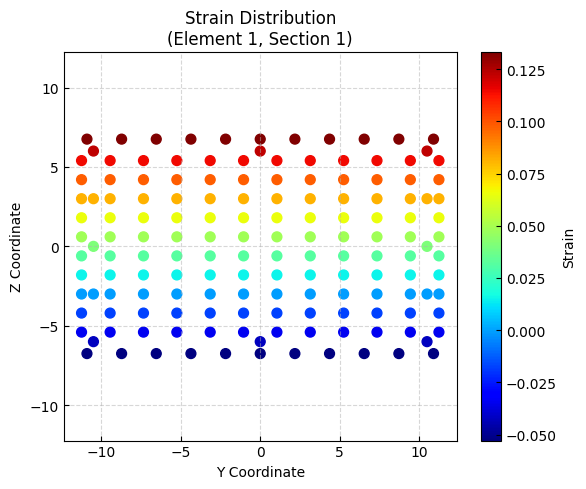

In [10]:
plt.figure(figsize=(6, 5))
scatter = plt.scatter(y, z, c=strain, cmap="jet", s=50)
plt.xlabel("Y Coordinate")
plt.ylabel("Z Coordinate")
plt.title("Strain Distribution\n(Element 1, Section 1)")
plt.colorbar(scatter, label="Strain")
plt.axis("equal")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

We can also extract stresses and strains for specific materials

In [11]:
stress = sec_resp["Stresses"].sel(eleTags=1, secPoints=1).isel(time=-1)
strain = sec_resp["Strains"].sel(eleTags=1, secPoints=1).isel(time=-1)
y = sec_resp["ys"].sel(eleTags=1, secPoints=1)
z = sec_resp["zs"].sel(eleTags=1, secPoints=1)
mat = sec_resp["matTags"].sel(eleTags=1, secPoints=1)

cond = (mat == 1) | (mat == 2)

matTag = 3 for rebar:

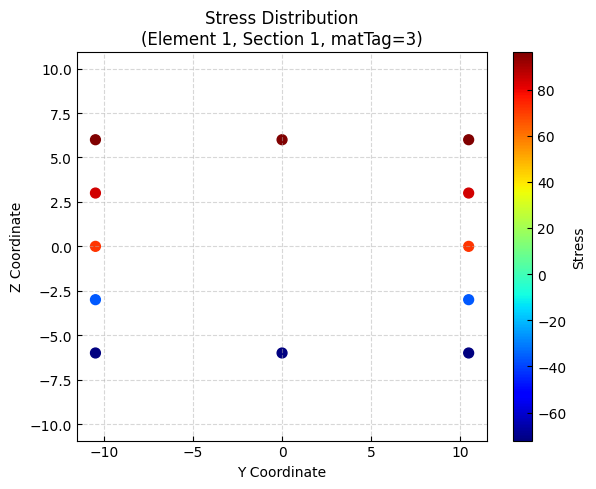

In [12]:
plt.figure(figsize=(6, 5))
scatter = plt.scatter(y[~cond], z[~cond], c=stress[~cond], cmap="jet", s=50)
plt.xlabel("Y Coordinate")
plt.ylabel("Z Coordinate")
plt.title("Stress Distribution\n(Element 1, Section 1, matTag=3)")
plt.colorbar(scatter, label="Stress")
plt.axis("equal")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

mattag = [1, 2] for concrete:

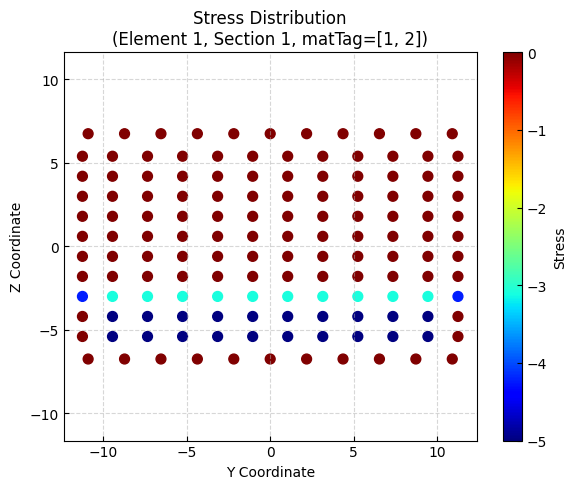

In [13]:
plt.figure(figsize=(6, 5))
scatter = plt.scatter(y[cond], z[cond], c=stress[cond], cmap="jet", s=50)
plt.xlabel("Y Coordinate")
plt.ylabel("Z Coordinate")
plt.title("Stress Distribution\n(Element 1, Section 1, matTag=[1, 2])")
plt.colorbar(scatter, label="Stress")
plt.axis("equal")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

We can also extract the force and deformation response at the cross-section level

In [14]:
defo = sec_resp["secDefo"].sel(eleTags=1, secPoints=1, DOFs="My")
fo = sec_resp["secForce"].sel(eleTags=1, secPoints=1, DOFs="My")
print(defo.head())

<xarray.DataArray 'secDefo' (time: 5)> Size: 40B
array([-2.55591352e-21,  2.12447549e-05,  5.34748850e-05,  8.39091896e-05,
        1.12386295e-04])
Coordinates:
    eleTags    int32 4B 1
    secPoints  int32 4B 1
    DOFs       <U2 8B 'My'
  * time       (time) float64 40B 0.0 0.6715 1.179 1.568 1.901


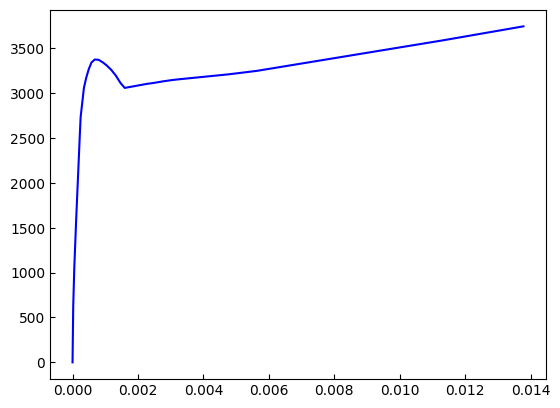

In [15]:
plt.plot(defo, fo, c="b")
plt.show()

### Frame elements

In [16]:
frame_resp = opst.post.get_element_responses(odb_tag=1, ele_type="Frame")
print(frame_resp)

OPSTOOL ::  Loading Frame response data from _OPSTOOL_ODB/RespStepData-1.nc ...

<xarray.Dataset> Size: 520kB
Dimensions:              (time: 152, eleTags: 3, localDofs: 12, basicDofs: 6,
                          secPoints: 7, secDofs: 6, locs: 4)
Coordinates:
  * eleTags              (eleTags) int32 12B 1 2 3
  * localDofs            (localDofs) <U3 144B 'FX1' 'FY1' 'FZ1' ... 'MY2' 'MZ2'
  * basicDofs            (basicDofs) <U3 72B 'N' 'MZ1' 'MZ2' 'MY1' 'MY2' 'T'
  * secPoints            (secPoints) int32 28B 1 2 3 4 5 6 7
  * secDofs              (secDofs) <U2 48B 'N' 'MZ' 'VY' 'MY' 'VZ' 'T'
  * locs                 (locs) <U5 80B 'alpha' 'X' 'Y' 'Z'
  * time                 (time) float64 1kB 0.0 0.6715 1.179 ... 3.359 3.355
Data variables:
    localForces          (time, eleTags, localDofs) float64 44kB 180.0 ... -1...
    basicForces          (time, eleTags, basicDofs) float64 22kB -180.0 ... -...
    basicDeformations    (time, eleTags, basicDofs) float64 22kB -0.01746 ......
    plasticDeformation   (time, eleTags, basicDofs) float64 22kB -0.0003215 ....
  

In [17]:
fo2 = frame_resp["sectionForces"].sel(eleTags=1, secPoints=1, secDofs="MY")
defo2 = frame_resp["sectionDeformations"].sel(eleTags=1, secPoints=1, secDofs="MY")

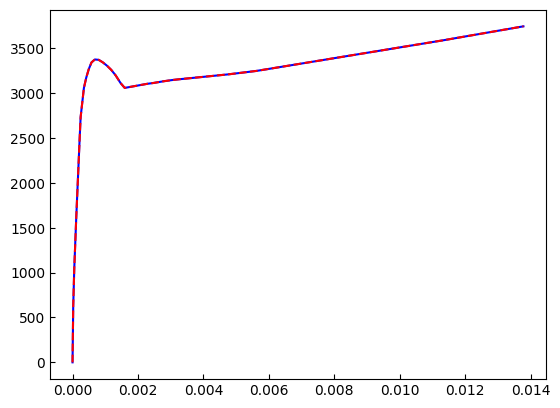

In [18]:
plt.plot(defo2, fo2, c="b")
plt.plot(defo, fo, "--r")
plt.show()

In [19]:
fos = frame_resp["sectionForces"].sel(eleTags=1, secDofs="MY").isel(time=-1)
defos = frame_resp["sectionDeformations"].sel(eleTags=1, secDofs="MY").isel(time=-1)

In [20]:
sec_loc = frame_resp["sectionLocs"].sel(eleTags=1)
xloc = sec_loc.sel(locs="X").isel(time=-1)
yloc = sec_loc.sel(locs="Y").isel(time=-1)
zloc = sec_loc.sel(locs="Z").isel(time=-1)

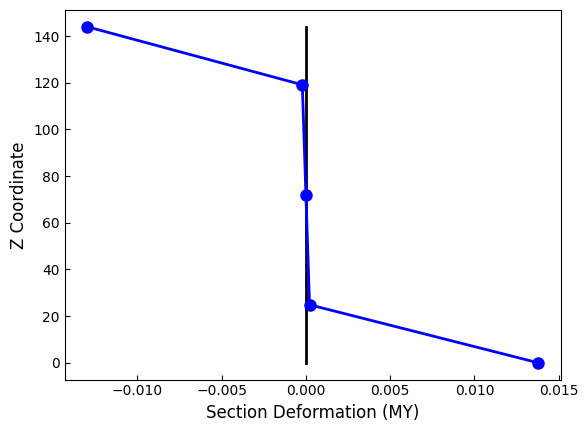

In [21]:
plt.plot(xloc, zloc, "-k", lw=2)
plt.plot(xloc + defos, zloc, "-b", lw=2, marker="o", markersize=8)
plt.xlabel("Section Deformation (MY)", fontsize=12)
plt.ylabel("Z Coordinate", fontsize=12)
plt.show()

In [ ]:
import matplotlib.animation as animation


fos = frame_resp["sectionForces"].sel(eleTags=1, secDofs="MY")
defos = frame_resp["sectionDeformations"].sel(eleTags=1, secDofs="MY")
nsteps = len(defos.time)

fig, ax = plt.subplots()
ax.set_xlabel("MY")
ax.set_ylabel("Z")

ax.plot(xloc, zloc, "-k", lw=2, label="Undeformed")
(line,) = ax.plot(xloc + fos.isel(time=-1), zloc, "-o", color="b", lw=2, markersize=6, label="Force")
ax.legend()


def animate(i):
    dx = fos.isel(time=i).values
    line.set_xdata(xloc + dx)
    line.set_ydata(zloc)
    return (line,)


# 创建动画
ani = animation.FuncAnimation(
    fig,
    animate,
    frames=nsteps,
    init_func=lambda: (line,),
    blit=True,
    interval=50,
)
ani.save("movie.gif")
plt.show()

![](movie.gif)